In [1]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/')
print(sys.path)

['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython']
['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/']


In [2]:
import numpy as np
import pandas as pd
import scvelo as sv
import anndata
import scanpy as sc
import time
import skdim
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.mstats import winsorize
from scipy import stats
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import os
os.environ['R_HOME'] = '/usr/lib/R'
import rpy2.robjects as ro
from collections import Counter


def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]

def preprocessing(adata,Already_Log_Transformed=False,Normalize_Totals=10000,
                                  Census_Normalization=False,top_variable_genes=10000):
    
    if Normalize_Totals>0:
        sc.pp.normalize_total(adata,target_sum=Normalize_Totals)
        
    if Census_Normalization:
        tc = np.array(adata.obs['total_counts'])
        gc = np.array(adata.obs['n_genes_by_counts'])
        X1 = adata.X/tc.reshape(-1,1)*gc.reshape(-1,1)
        adata.X = X1
    
    if not Already_Log_Transformed:
        sc.pp.log1p(adata)
        
    if top_variable_genes>0:
        #sc.pp.highly_variable_genes(adata,n_top_genes=top_variable_genes,n_bins=20)
        #ind_genes = np.where(adata.var['highly_variable'])[0]
        vars = np.var(adata.X,axis=0)
        inds = np.flip(np.argsort(vars))
        ind_genes = inds[0:top_variable_genes]
        adata.uns['ind_genes'] = ind_genes
        if 0 in vars[ind_genes]:
            ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
            ind_genes = ind_genes[0:ind_first_zero]
        #print(vars[ind_genes])
        adata = adata[:,ind_genes]
    sc.tl.pca(adata,n_comps=number_of_pcs)
    return adata

# pooling procedure
def pooling_procedure(adata,n_neighbours_for_pooling=10):
    if n_neighbours_for_pooling>0:    
        adata_work = adata_orig.copy()
        #adata = preprocessing(adata)
        sc.tl.pca(adata,n_comps=number_of_pcs)
        X_pca = adata.obsm['X_pca']
        adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours_for_pooling)
    return adata

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled

def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

def get_surrogate_signature(adata,score,n_top_genes=200,negative_side=False,producePlot=False):
    X = adata.X.T
    gene_corrs = np.zeros(len(X))
    for i in range(len(X)):
        gene_corrs[i] = stats.spearmanr(X[i,:],score)[0]
    #mn_corr = np.mean(np.abs(gene_corrs))
    if not negative_side:
        inds = np.flip(np.argsort(gene_corrs))
    else:
        inds = np.argsort(gene_corrs)
    #print(gene_corrs[inds])
    inds_top = inds[0:n_top_genes]
    signature_gene_names = adata.var_names[inds_top]
    signature_scores = np.mean(X[inds_top,:],axis=0)
    signature_scores = (signature_scores-np.min(signature_scores))/(np.max(signature_scores)-np.min(signature_scores))
    signature_scores = np.min(score)+signature_scores*(np.max(score)-np.min(score))
    #print(*signature_gene_names)
    if producePlot:
        plt.scatter(score,signature_scores,c='k')
        plt.xlabel('Initial score')
        plt.ylabel('Surrogate score')
        plt.title('Corr = '+str(stats.spearmanr(signature_scores,score)[0]))
        plt.show()
    return signature_gene_names,signature_scores,gene_corrs,inds_top

def weighted_mean(x, w):
    """Weighted Mean"""
    return np.average(x,weights=w)
def mean_inversely_weighted_by_classes(x,classes):
    weights = np.ones(len(x))
    counter = Counter(classes)
    for key in counter.keys():
        nk = counter[key]
        wk = len(x)/nk
        #print(classes)
        #print(key)
        #print(np.argwhere(classes==key).flatten())
        weights[np.argwhere(classes==key).flatten()] = wk
    return weighted_mean(x,weights)
def weighterd_covariance(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - weighted_mean(x, w)) * (y - weighted_mean(y, w))) / np.sum(w)
def weighted_pearson_corr(x, y, w):
    """Weighted Correlation"""
    return weighterd_covariance(x, y, w) / np.sqrt(weighterd_covariance(x, x, w) * weighterd_covariance(y, y, w))
def pearson_inversely_weighted_by_classes(x,y,classes):
    weights = np.ones(len(x))
    counter = Counter(classes)
    for key in counter.keys():
        nk = counter[key]
        wk = len(x)/nk
        #print(classes)
        #print(key)
        #print(np.argwhere(classes==key))
        weights[np.argwhere(classes==key)] = wk
    return weighted_pearson_corr(x,y,weights)

def spearman_inversely_weighted_by_classes(x,y,classes,resolve_ties=None):
    xr = stats.rankdata(x)
    yr = stats.rankdata(y)
    #if resolve_ties is not None:
    return pearson_inversely_weighted_by_classes(xr,yr,classes)



/home/zinovyev/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
#adata_orig = sc.read_loom('/mnt/c/Datas/ExpressionIDim/DentateGyrus/DentateGyrus.loom')
adata_orig = anndata.read_h5ad('/mnt/c/Datas/ExpressionIDim/DentateGyrus/DG.h5ad')

#Read already qc-processed dataset
#adata_orig = anndata.read_h5ad('/mnt/c/Datas/ExpressionIDim/GSE104323/GSE104323_qc.h5ad')

#Read already qc-processed and filtered from unrelevant cell types dataset
#adata_orig = anndata.read_h5ad('/mnt/c/Datas/ExpressionIDim/GSE104323/GSE104323_qc_filtered.h5ad')

#Read qc-processed and normalized dataset
#adata_orig = anndata.read_h5ad('/mnt/c/Datas/ExpressionIDim/GSE104323/GSE104323_qc_norm.h5ad')

display(adata_orig)
adata = adata_orig.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CytoTRACE', 'Order_cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'CytoGenes'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
# filling in some fields
#adata_orig.obs['total_counts'] = np.array(np.sum(adata.X,axis=1).ravel()).reshape(-1)
#adata_orig.obs['n_genes_by_counts'] = np.array(np.sum(adata.X>0,axis=1).ravel()).reshape(-1)
adata_orig.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_orig, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# convert to dense matrix
X = adata_orig.X.toarray()
adata_orig.X = X

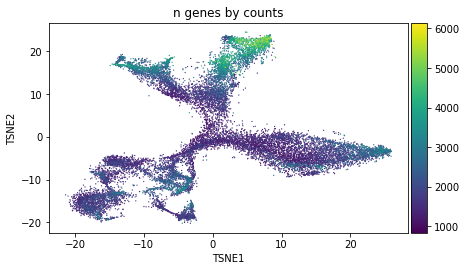

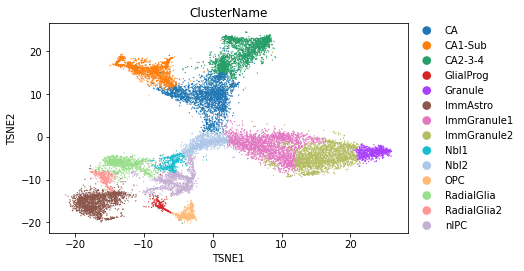

In [4]:
field = 'Clusters'
field = 'ClusterName'
classes = adata.obs[field]
classes_unique = np.unique(adata.obs[field])

#plt.figure(figsize=(10,10))
#for cl in classes_unique:
#    plt.scatter(adata.obs['TSNE1'][classes==cl],adata.obs['TSNE2'][classes==cl],s=5,label=cl)
#plt.legend()
#plt.show()
sc.pl.scatter(adata,x='TSNE1',y='TSNE2',color='n_genes_by_counts')
sc.pl.scatter(adata,x='TSNE1',y='TSNE2',color='ClusterName')

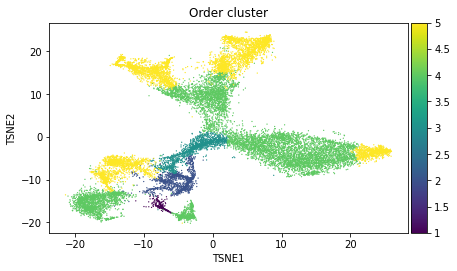

In [33]:
Order_cluster = {'CA':4,'CA1-Sub':5,'CA2-3-4':5,'GlialProg':1,'Granule':5,
                 'ImmAstro':4,'ImmGranule1':4,'ImmGranule2':4,
                 'Nbl1':3,'Nbl2':3,
                 'OPC':4,
                 'RadialGlia':5,
                 'RadialGlia2':5,
                 'nIPC':2}

adata.obs['Order_cluster'] = adata.obs['ClusterName'].replace(to_replace=Order_cluster)
adata_orig.obs['Order_cluster'] = adata.obs['ClusterName'].replace(to_replace=Order_cluster)

sc.pl.scatter(adata,x='TSNE1',y='TSNE2',color='Order_cluster')

In [28]:
# PREPROCESSING

adata = adata_orig.copy()

# all preprocessing parameters

number_of_pcs = 50

Already_Log_Transformed = False
top_variable_genes = 10000 # if negative then no selection of genes
Normalize_Totals = -1
Census_normalization = True
n_neighbours_for_pooling = -1

print('PREPROCESSING PARAMETERS:')

print('Already_Log_Transformed=',Already_Log_Transformed)
print('Normalize_Totals=',Normalize_Totals)
print('Census_normalization=',Census_normalization)
print('number_of_pcs=',number_of_pcs)
print('n_neighbours_for_pooling=',n_neighbours_for_pooling)
print('top_variable_genes=',top_variable_genes)

if n_neighbours_for_pooling>0:
    print('Initial preprocessing...')
    adata = preprocessing(adata,Already_Log_Transformed=Already_Log_Transformed,
                         top_variable_genes=top_variable_genes,
                         Normalize_Totals=Normalize_Totals,
                         Census_Normalization=Census_normalization)
    print('Pooling...')
    adata = pooling_procedure(adata,n_neighbours_for_pooling=n_neighbours_for_pooling)

print('Final preprocessing...')
adata = preprocessing(adata,Already_Log_Transformed=Already_Log_Transformed,
                         top_variable_genes=top_variable_genes,
                         Normalize_Totals=Normalize_Totals,
                         Census_Normalization=Census_normalization)

print('Computing PCA on pre-processed data...')
sc.tl.pca(adata,n_comps=number_of_pcs)
X_pca = adata.obsm['X_pca']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PREPROCESSING PARAMETERS:
Already_Log_Transformed= False
Normalize_Totals= -1
Census_normalization= True
number_of_pcs= 50
n_neighbours_for_pooling= -1
top_variable_genes= 10000
Final preprocessing...
Computing PCA on pre-processed data...


In [6]:
# CytoTRACE analysis - the results will be in adata.obs['CytoTRACE'] and in adata.uns['CytoGenes'], no need to repeat if already made

import time
from scipy.stats import gaussian_kde

%load_ext rpy2.ipython
%R source('/mnt/c/Libraries/CytoTRACE/R/CytoTRACE.R')

adata_cytotrace = adata_orig
display(adata_cytotrace)
input_cyto=pd.DataFrame(adata_cytotrace.X.T)

s=time.time()
%R -i input_cyto
print('Loaded in ',round(time.time()-s,2),'sec')

cytotrace = %R cytotrace <- CytoTRACE(input_cyto)
cytotrace_score = np.array(cytotrace.rx2('CytoTRACE'))
cytotrace_genes = np.array(cytotrace.rx2('cytoGenes'))
adata_orig.obs['CytoTRACE'] = cytotrace_score
adata_orig.uns['CytoGenes'] = cytotrace_genes

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Loaded in  1045.62 sec


R[write to console]: The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

R[write to console]: CytoTRACE will be run on 18 sub-sample(s) of approximately 1012 cells each using 1 / 1 core(s)

R[write to console]: Pre-processing data and generating similarity matrix...

R[write to console]: Calculating gene counts signature...

R[write to console]: Smoothing values with NNLS regression and diffusion...

R[write to console]: Calculating genes associated with CytoTRACE...

R[write to console]: Done



In [34]:
adata.obs['PC1'] = X_pca[:,0]
X = adata.X.T
gene_corrs = np.zeros(len(X))
for k in range(len(X)):
    gene_corrs[k] = stats.pearsonr(X[k,:],X_pca[:,0])[0]
    if np.mean(gene_corrs)<0:
        adata.obs['PC1'] = -X_pca[:,0]

adata.obs['PC2'] = X_pca[:,1]
X = adata.X.T
gene_corrs = np.zeros(len(X))
for k in range(len(X)):
    gene_corrs[k] = stats.pearsonr(X[k,:],X_pca[:,1])[0]
    if np.mean(gene_corrs)<0:
        adata.obs['PC2'] = -X_pca[:,1]

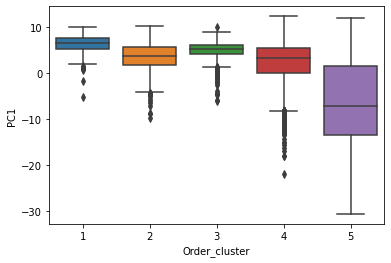

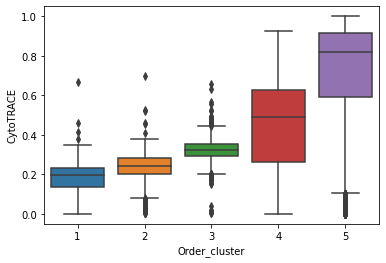

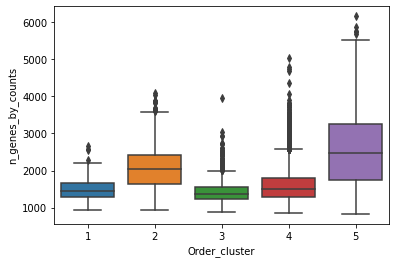

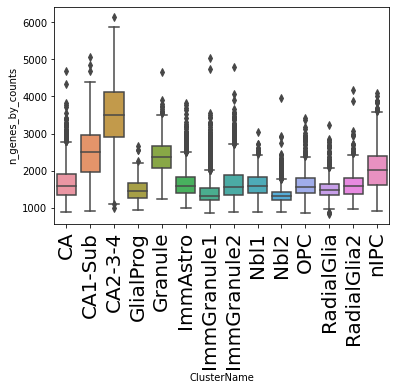

Corr PC1/Order_cluster -0.547802881227471
Corr CytoTRACE/Order_cluster 0.6782726712599556


In [35]:
sns.boxplot(data=adata.obs,x='Order_cluster',y='PC1')
plt.show()
sns.boxplot(data=adata.obs,x='Order_cluster',y='CytoTRACE')
plt.show()
sns.boxplot(data=adata.obs,x='Order_cluster',y='n_genes_by_counts')
plt.show()
sns.boxplot(data=adata.obs,x='ClusterName',y='n_genes_by_counts')
plt.xticks(rotation='vertical',fontsize=20)
plt.show()


temp = np.array(adata.obs['PC1'])
order = np.array(adata.obs['Order_cluster'])
print('Corr PC1/Order_cluster',spearman_inversely_weighted_by_classes(temp,order,order))
temp = np.array(adata.obs['CytoTRACE'])
order = np.array(adata.obs['Order_cluster'])
print('Corr CytoTRACE/Order_cluster',spearman_inversely_weighted_by_classes(temp,order,order))

In [31]:
# FisherS GPW analysis

conditional_number = 20
print(X_pca.shape)
if False:
    for cond_number in range(5,30):
        fishers = skdim.lid.FisherS(conditional_number=cond_number).fit(X_pca)
        glob_pw = fishers.point_inseparability_to_pointID(idx='selected')[0]
        glob_pw = winsorize(glob_pw, limits=(0.01,0.01), inclusive=(True, True), inplace=True)
        order = np.array(adata_reduced.obs['Order'])
        corr = spearman_inversely_weighted_by_classes(order,glob_pw[ind_samples],order)
        print(cond_number,':',corr,'reduced dim',fishers.Xp_.shape[1])
print('\nCONDITIONAL NUMBER:',conditional_number)
print('Computing the FisherS GPW...')
fishers = skdim.lid.FisherS(conditional_number=conditional_number).fit(X_pca)
print('Reduced dim=',fishers.Xp_.shape[1])
glob_pw = fishers.point_inseparability_to_pointID(idx='selected')[0]
print('Computing the knn graph...')
X_pca = adata.obsm['X_pca']
_, knn = skdim.get_nn(X_pca, k=100, n_jobs=4)
print('Computing the mean dimension...')
glob_pw_mean = skdim.mean_local_id(glob_pw,knn)
glob_pw = winsorize(glob_pw, limits=(0.01,0.01), inclusive=(True, True))
glob_pw1 = winsorize(glob_pw, limits=(0.05,0.05), inclusive=(True, True))
adata.obs['FisherS_GPW_vis'] = glob_pw1
adata.obs['FisherS_GPW'] = glob_pw
adata.obs['FisherS_GPW_mean'] = glob_pw_mean
print('Computing surrogate signature...')
_,surrogate_glob_pw,_,_ = get_surrogate_signature(adata,glob_pw,n_top_genes=200)
surrogate_glob_pw1 = winsorize(surrogate_glob_pw, limits=(0.05,0.05), inclusive=(True, True))
adata.obs['FisherS_GPW_surrogate'] = surrogate_glob_pw
adata.obs['FisherS_GPW_surrogate_vis'] = surrogate_glob_pw1

(18213, 50)

CONDITIONAL NUMBER: 20
Computing the FisherS GPW...
Reduced dim= 5
Computing the knn graph...
Computing the mean dimension...
Computing surrogate signature...


Corr FisherS_GPW/Order_cluster -0.10778427285855376
Corr FisherS_GPW_mean/Order_cluster -0.07429652816220363
Corr FisherS_GPW_surrogate/Order_cluster 0.2578658961963905


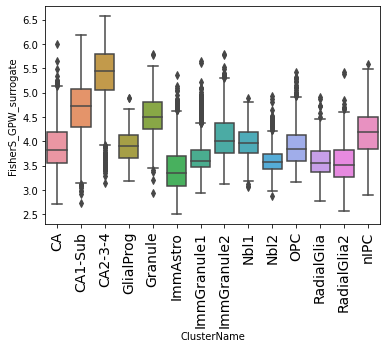

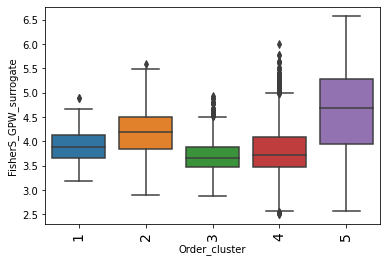

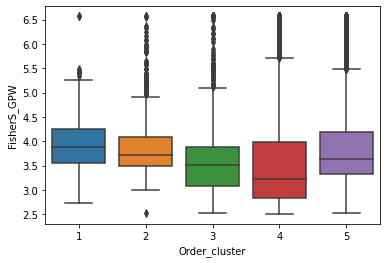

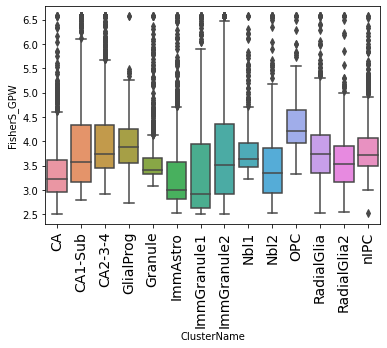

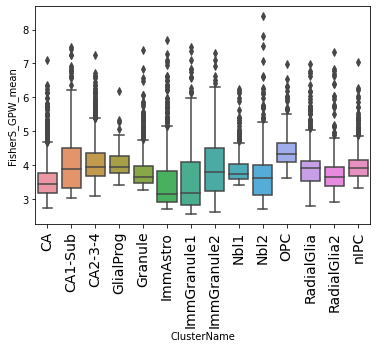

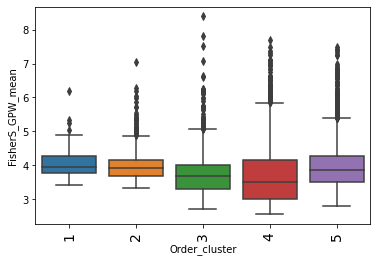

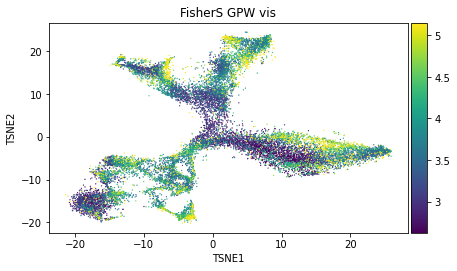

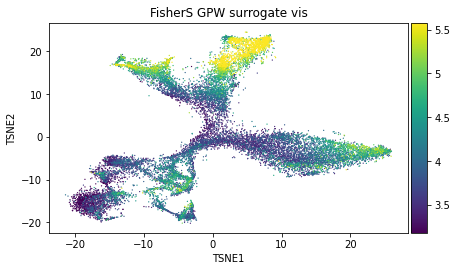

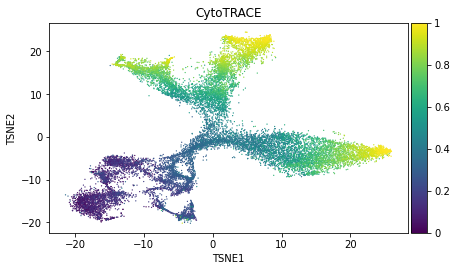

In [36]:
FisherS_GPW = np.array(adata.obs['FisherS_GPW'])
FisherS_GPW_mean = np.array(adata.obs['FisherS_GPW_mean'])
FisherS_GPW_surrogate = np.array(adata.obs['FisherS_GPW_surrogate'])
order_cluster = np.array(adata.obs['Order_cluster'])
print('Corr FisherS_GPW/Order_cluster',spearman_inversely_weighted_by_classes(FisherS_GPW,order_cluster,order_cluster))
print('Corr FisherS_GPW_mean/Order_cluster',spearman_inversely_weighted_by_classes(FisherS_GPW_mean,order_cluster,order_cluster))
print('Corr FisherS_GPW_surrogate/Order_cluster',spearman_inversely_weighted_by_classes(FisherS_GPW_surrogate,order_cluster,order_cluster))

sns.boxplot(data=adata.obs,x='ClusterName',y='FisherS_GPW_surrogate')
plt.xticks(rotation='vertical',fontsize=14)
plt.show()
sns.boxplot(data=adata.obs,x='Order_cluster',y='FisherS_GPW_surrogate')
plt.xticks(rotation='vertical',fontsize=14)
plt.show()
sns.boxplot(data=adata.obs,x='Order_cluster',y='FisherS_GPW')
plt.show()
sns.boxplot(data=adata.obs,x='ClusterName',y='FisherS_GPW')
plt.xticks(rotation='vertical',fontsize=14)
plt.show()
sns.boxplot(data=adata.obs,x='ClusterName',y='FisherS_GPW_mean')
plt.xticks(rotation='vertical',fontsize=14)
plt.show()
sns.boxplot(data=adata.obs,x='Order_cluster',y='FisherS_GPW_mean')
plt.xticks(rotation='vertical',fontsize=14)
plt.show()

sc.pl.scatter(adata,x='TSNE1',y='TSNE2',color='FisherS_GPW_vis')
sc.pl.scatter(adata,x='TSNE1',y='TSNE2',color='FisherS_GPW_surrogate_vis')
sc.pl.scatter(adata,x='TSNE1',y='TSNE2',color='CytoTRACE')


In [12]:
#adata.write('/mnt/c/Datas/ExpressionIDim/DentateGyrus/DG_norm.h5ad',compression='gzip')
#adata_orig.write('/mnt/c/Datas/ExpressionIDim/DentateGyrus/DG.h5ad',compression='gzip')